In [1]:
import pandas as pd
import numpy as np
from keras.src.distribute.saved_model_test_base import strategies
from tqdm import tqdm

In [2]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df / df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()    # same with (return_df.cumsum() + 1)

def get_CAGR_series(cum_rtn_df, num_day_in_year=250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df):
    # 1. Drawdown
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df - 1

    # 2. Maximum drawdown
    mdd_series = dd_df.min()

    # 3. longest_dd_period
    dd_duration_info_list = list()
    max_point_df = dd_df[dd_df == 0]
    for col in max_point_df:
        _df = max_point_df[col]
        _df.loc[dd_df[col].last_valid_index()] = 0
        _df = _df.dropna()

        periods = _df.index[1:] - _df.index[:-1]

        days = periods.days
        max_idx = days.argmax()

        longest_dd_period = days.max()
        dd_mean = int(np.mean(days))
        dd_std = int(np.std(days))

        dd_duration_info_list.append(
            [
                dd_mean,
                dd_std,
                longest_dd_period,
                "{} ~ {}".format(_df.index[:-1][max_idx].date(), _df.index[1:][max_idx].date())
            ]
        )

    dd_duration_info_df = pd.DataFrame(
        dd_duration_info_list,
        index=dd_df.columns,
        columns=['drawdown mean', 'drawdown std', 'longest days', 'longest period']
    )
    return dd_df, mdd_series, dd_duration_info_df

In [3]:
from functools import reduce

def calculate_portvals(price_df, weight_df):
    cum_rtn_up_until_now = 1
    individual_port_val_df_list = []

    prev_end_day = weight_df.index[0]
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        sub_asset_flow_df = sub_price_df / sub_price_df.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        indi_port_cum_rtn_series = (sub_asset_flow_df * weight_series) * cum_rtn_up_until_now

        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

def get_rebal_dates(price_df, period="month"):
    _price_df = price_df.reset_index()
    if period == "month":
         groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month]
    elif period == "quarter":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.quarter]
    elif period == "halfyear":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month // 7]
    elif period == "year":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.year]
    rebal_dates = pd.to_datetime(_price_df.groupby(groupby)['date_time'].last().values)
    return rebal_dates

In [4]:
result_portval_dict = {}

In [5]:
# Buy and Hold
all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()

individual_port_val_df = price_df / price_df.iloc[0] * [0.5, 0.5]
result_portval_dict['buy_and_hold'] = individual_port_val_df.sum(axis=1)

In [8]:
all_ticker_price_df.head()

,AGG,BND,EEM,EWJ,GLD,GSG,HYG,IEF,IEI,IJS,...,SHV,SHY,SPY,TLT,UST,VEA,VGK,VNQ,VTI,VWO
date_time,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,47.17861,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,97.50794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,45.89642,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.69317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,44.61423,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.86078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,42.80752,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,92.35230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,43.71088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,97.71577,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
all_ticker_price_df.columns

Index(['AGG', 'BND', 'EEM', 'EWJ', 'GLD', 'GSG', 'HYG', 'IEF', 'IEI', 'IJS',
       'IWM', 'LQD', 'QQQ', 'SHV', 'SHY', 'SPY', 'TLT', 'UST', 'VEA', 'VGK',
       'VNQ', 'VTI', 'VWO'],
      dtype='object')

In [32]:
import itertools
from typing import Iterable, List, Tuple, Generator

def generate_daa_combinations(
    all_ticker_columns: Iterable[str],
) -> Generator[Tuple[List[str], List[str], List[str]], None, None]:
    """
    DAA 전략용 공격형/방어형/카나리아 자산군 모든 조합을 생성하는 제너레이터.

    입력:
        all_ticker_columns: 티커 문자열 iterable (리스트 등)

    제약:
        1. len(all_ticker_columns) >= 3 이어야 한다.
        2. 공격형(offense)과 방어형(defense)은 서로 중복 불가.
        3. 카나리아(canary)는 공격형/방어형과 중복 가능.
        4. 각 자산군(공격형, 방어형, 카나리아)에 최소 1개 이상 포함.

    반환:
        매 이터레이션마다
        offense_assets, defense_assets, canary_assets
        세 리스트를 튜플로 반환한다.
    """
    all_ticker_columns = list(all_ticker_columns)
    n = len(all_ticker_columns)

    if n < 3:
        raise ValueError("all_ticker_columns 길이는 최소 3 이상이어야 합니다.")

    # 각 티커에 대해 상태 코드:
    # 0: 공격형(offense)
    # 1: 방어형(defense)
    # 2: 어느 쪽에도 속하지 않음
    #
    # -> offense / defense 구성을 위한 3진(product) 탐색
    for states in itertools.product((0, 1, 2), repeat=n):
        # 공격형과 방어형에 최소 1개씩은 있어야 한다.
        if 0 not in states or 1 not in states:
            continue

        offense_assets = [
            ticker for ticker, s in zip(all_ticker_columns, states) if s == 0
        ]
        defense_assets = [
            ticker for ticker, s in zip(all_ticker_columns, states) if s == 1
        ]

        # 카나리아 자산군: 전체 all_ticker_columns에서 나올 수 있는
        # 모든 "비어 있지 않은" 부분집합
        for k in range(1, n + 1):
            for canary_subset in itertools.combinations(all_ticker_columns, k):
                canary_assets = list(canary_subset)
                # 여기서 최종 조합 하나를 반환 (yield)
                yield offense_assets, defense_assets, canary_assets


In [33]:
def set_weight(series):
    canary_score = series.loc["canary_signal"]
    if canary_score == 0:
        target_assets = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series([1], index=target_assets)
    elif canary_score == 1:
        target_assets1 = series.loc[offense_assets].sort_values().iloc[-2:].index
        target_assets2 = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series(
            [0.25, 0.25, 0.5],
            index=target_assets1.tolist() + target_assets2.tolist()
        )
    else:
        target_assets = series.loc[offense_assets].sort_values().iloc[-2:].index
        return pd.Series([0.5, 0.5], index=target_assets)

In [34]:
all_ticker_columns = ["SPY", "GLD", "HYG", "SHV", "IEF", "TLT", "VWO", "BND"]


In [35]:
offense_assets = ["SPY", "GLD", "HYG"]
defense_assets = ["SHV", "IEF", "TLT"]  # UST대신 TLT로 대체
canary_assets = ["VWO", "BND"]   # VWO는 offense_asset에도 존재

In [36]:
all_ticker_columns = ["SPY", "GLD", "HYG", "SHV", "IEF", "TLT", "VWO", "BND"]


In [37]:
import random
from typing import Iterable, List, Tuple, Generator

def sample_daa_combinations(
    all_ticker_columns: Iterable[str],
    n_samples: int,
    max_trials: int = 100_000,
    random_state: int  = None,
) -> Generator[Tuple[List[str], List[str], List[str]], None, None]:
    """
    DAA 전략용 조합을 전체 가능한 경우 중 무작위 샘플링해서
    (offense_assets, defense_assets, canary_assets)를 차례대로 yield.

    조건
    ----
    1. len(all_ticker_columns) >= 3
    2. offense_assets, defense_assets, canary_assets는 각각 최소 1개 이상
    3. offense_assets와 defense_assets는 서로 중복 불가
    4. canary_assets는 offense/defense와 중복 가능
    5. len(canary_assets) < len(offense_assets)
       AND len(canary_assets) < len(defense_assets)
    6. 최대 n_samples개까지 서로 다른 조합을 중복 없이 샘플링

    주의
    ----
    - 가능한 유효 조합 수 자체가 적거나,
      max_trials에 비해 n_samples가 너무 크면
      n_samples보다 적게 생성될 수 있습니다.
    """
    tickers = list(all_ticker_columns)
    n = len(tickers)

    if n < 3:
        raise ValueError("all_ticker_columns 길이는 최소 3 이상이어야 합니다.")
    if n_samples < 1:
        raise ValueError("n_samples는 1 이상이어야 합니다.")

    rng = random.Random(random_state)

    seen = set()        # 중복 조합 방지용 (canonical key 저장)
    produced = 0
    trials = 0

    while produced < n_samples and trials < max_trials:
        trials += 1

        # 1) 공격형(offense) 선택
        #    최소 1개, 최대 n-2개 (defense, canary를 위해 최소 1개씩 남김)
        max_offense_size = max(1, n - 2)
        offense_size = rng.randint(1, max_offense_size)
        offense_assets = rng.sample(tickers, offense_size)

        # 2) 방어형(defense) 선택 (공격형과 중복 불가)
        remaining_for_defense = [t for t in tickers if t not in offense_assets]
        if len(remaining_for_defense) < 2:
            # 방어형 1개 + 카나리아 최소 1개를 만들 공간이 안 나옴
            continue
        max_defense_size = len(remaining_for_defense) - 1  # 카나리아 최소 1개 확보
        if max_defense_size < 1:
            continue
        defense_size = rng.randint(1, max_defense_size)
        defense_assets = rng.sample(remaining_for_defense, defense_size)

        # 3) 카나리아 크기 결정
        #    카나리아 < 공격형, 카나리아 < 방어형 조건 반영
        max_canary_size = min(
            len(tickers),           # 전체 티커 수
            len(offense_assets) - 1,
            len(defense_assets) - 1,
        )
        if max_canary_size < 1:
            continue
        canary_size = rng.randint(1, max_canary_size)

        # 4) 카나리아 선택 (공격/방어와 중복 허용)
        canary_assets = rng.sample(tickers, canary_size)

        # 5) 조건 검증 (안전망)
        if not offense_assets or not defense_assets or not canary_assets:
            continue
        if set(offense_assets) & set(defense_assets):
            # 공격형과 방어형은 절대 겹치면 안 됨
            continue
        if not (
            len(canary_assets) < len(offense_assets)
            and len(canary_assets) < len(defense_assets)
        ):
            continue

        # 6) canonical key로 중복 제거 (정렬 후 튜플화)
        key = (
            tuple(sorted(offense_assets)),
            tuple(sorted(defense_assets)),
            tuple(sorted(canary_assets)),
        )
        if key in seen:
            continue

        seen.add(key)
        produced += 1
        yield offense_assets, defense_assets, canary_assets

    # n_samples보다 적게 생성되면 그냥 거기까지 yield됨


In [38]:
all_ticker_columns = ["SPY", "QQQ", "IWM", "EEM", "TLT", "IEF", "LQD", "GLD"]

# 샘플 1,000개 뽑기
for offense_assets, defense_assets, canary_assets in tqdm(sample_daa_combinations(all_ticker_columns=all_ticker_columns, n_samples=100, random_state=42)):
    # 여기서 각 조합별로 백테스트 실행
    # backtest(offense_assets, defense_assets, canary_assets)
    # print("공격형:", offense_assets, "방어형:", defense_assets, "카나리아:", canary_assets)

    strategy_name = "+".join(offense_assets) + '_' + "+".join(defense_assets) + '_' + "+".join(canary_assets)
    price_df = all_ticker_price_df[
        list(set(offense_assets + defense_assets + canary_assets))
    ]

    price_df = price_df.dropna()
    rebal_dates = get_rebal_dates(price_df)

    momentum_df = price_df.loc[rebal_dates].copy()

    momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                          + (2 * momentum_df.pct_change(6)) \
                                                          + (1 * momentum_df.pct_change(12))

    momentum_result_df = momentum_result_df.dropna()

    # 카나리 신호 계산
    canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)

    momentum_result_df['canary_signal'] = canary_signal_series

    target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)

    individual_port_val_df = calculate_portvals(price_df, target_weight_df)

    result_portval_dict[strategy_name] = individual_port_val_df.sum(axis=1)

100it [01:01,  1.64it/s]


In [39]:
len(result_portval_dict)

101

In [40]:
# 포트폴리오 종합 비교
compare_df = pd.DataFrame(result_portval_dict).dropna()
compare_df = compare_df / compare_df.iloc[0]

In [41]:
get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio").head(10)

,Sharpe Ratio
SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT,0.871134
GLD+LQD_QQQ+SPY+TLT+IWM_IEF,0.859756
IWM+GLD+SPY_TLT+QQQ_TLT,0.852709
EEM+SPY+IEF_TLT+QQQ_EEM,0.825116
QQQ+GLD+EEM+TLT_IEF+LQD_SPY,0.823093
IEF+LQD+SPY+GLD_QQQ+TLT_TLT,0.810282
TLT+GLD+EEM_SPY+QQQ+IEF_IEF,0.793003
QQQ+TLT+LQD+GLD+IWM_IEF+SPY_QQQ,0.756607
EEM+IWM+QQQ+SPY_TLT+IEF_EEM,0.742705
GLD+EEM+IWM+TLT_IEF+LQD_QQQ,0.730947


In [42]:
top_10_sharpe_ratio = get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio").head(10).index.to_list()

<Axes: xlabel='date_time'>

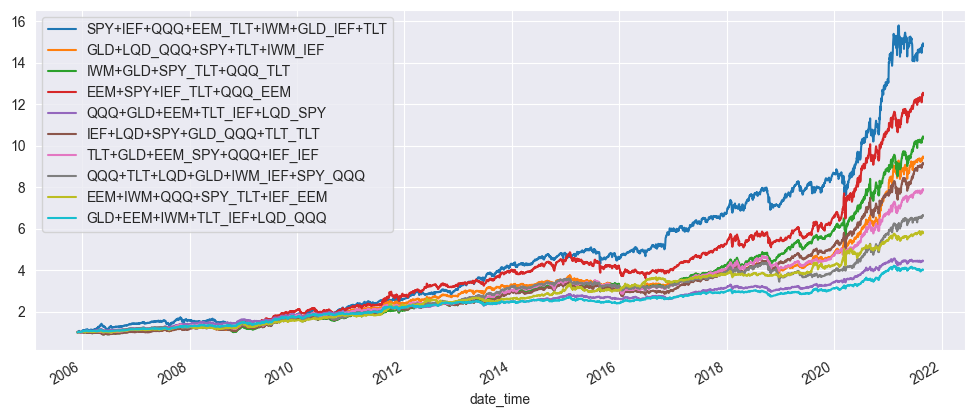

In [43]:
compare_df[top_10_sharpe_ratio].plot(figsize=(12, 5))

In [44]:
get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR").head(10)

,CAGR
SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT,0.185934
EEM+SPY+IEF_TLT+QQQ_EEM,0.173007
IWM+GLD+SPY_TLT+QQQ_TLT,0.159506
GLD+LQD_QQQ+SPY+TLT+IWM_IEF,0.152412
IEF+QQQ+EEM+SPY_TLT+IWM_QQQ,0.149992
IEF+LQD+SPY+GLD_QQQ+TLT_TLT,0.149974
SPY+IEF+LQD+TLT+IWM_GLD+QQQ_GLD,0.149584
EEM+IEF+LQD_QQQ+IWM+GLD_TLT,0.147326
LQD+GLD_IWM+SPY+EEM+TLT+QQQ_GLD,0.144959
GLD+IWM_IEF+LQD+EEM+SPY+TLT_EEM,0.139370


In [45]:
top_10_cagr = get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR").head(10).index.to_list()

<Axes: xlabel='date_time'>

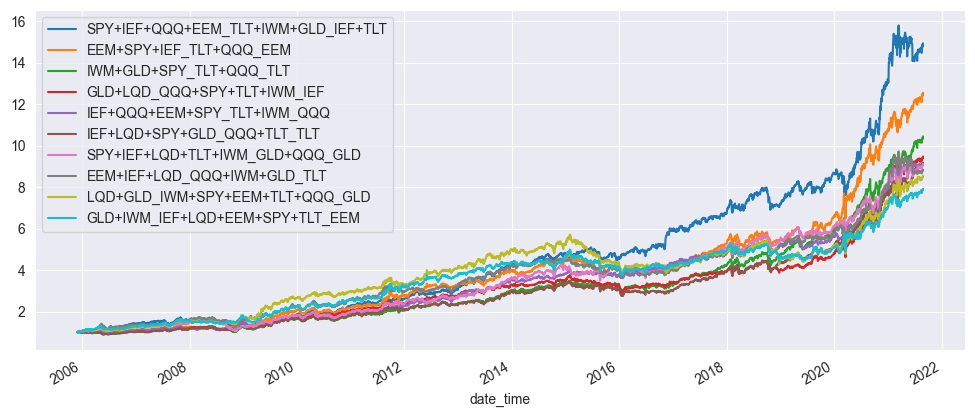

In [46]:
compare_df[top_10_cagr].plot(figsize=(12, 5))

<Axes: xlabel='date_time'>

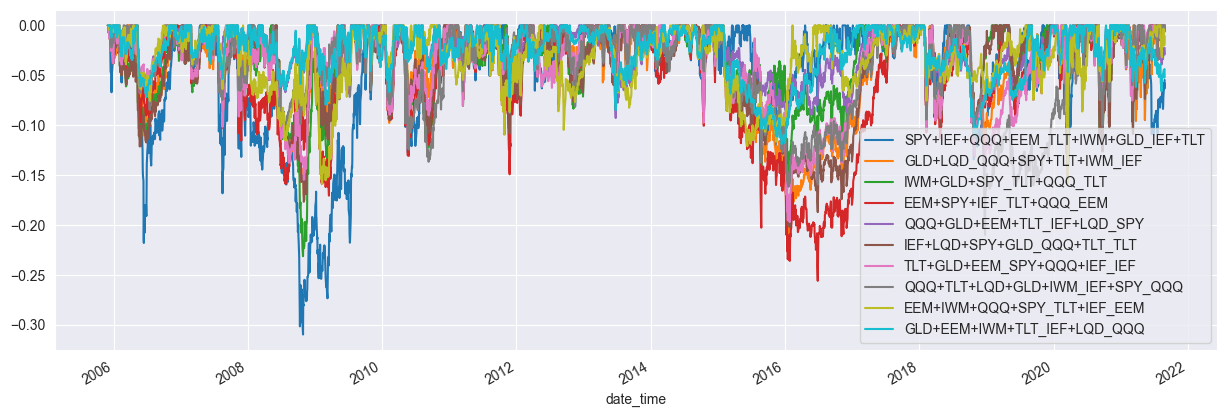

In [47]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_sharpe_ratio])
dd_df.plot(figsize=(15, 5))

<Axes: xlabel='date_time'>

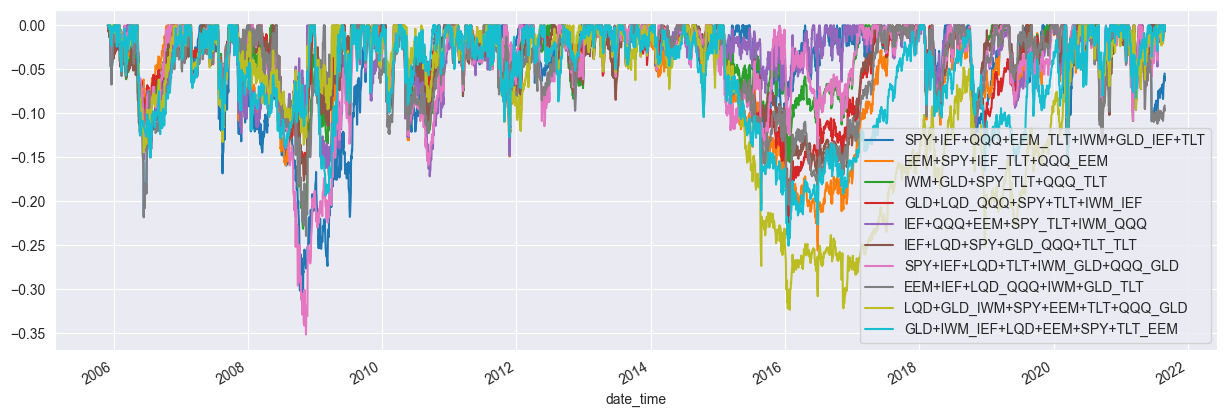

In [48]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_cagr])
dd_df.plot(figsize=(15, 5))

In [49]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df)

In [50]:
mdd_series.sort_values().to_frame("MDD").tail(10)

,MDD
SPY+IWM+LQD+QQQ_IEF+TLT_GLD,-0.173881
IEF+QQQ+EEM+SPY_TLT+IWM_QQQ,-0.171506
GLD+IWM+QQQ+LQD_TLT+IEF_SPY,-0.171196
LQD+IEF_IWM+TLT_GLD,-0.170813
LQD+QQQ+TLT_EEM+IEF_GLD,-0.161521
EEM+IWM+QQQ+SPY_TLT+IEF_EEM,-0.158572
QQQ+TLT+LQD_IWM+IEF_QQQ,-0.152536
GLD+TLT_IEF+SPY+LQD+EEM_SPY,-0.149917
GLD+EEM+IWM+TLT_IEF+LQD_QQQ,-0.118799
QQQ+GLD+EEM+TLT_IEF+LQD_SPY,-0.104952


In [51]:
longest_dd_period_df.sort_values(by='drawdown mean').head(10)

,drawdown mean,drawdown std,longest days,longest period
buy_and_hold,9,44,897,2007-10-31 ~ 2010-04-15
IWM+GLD+SPY_TLT+QQQ_TLT,10,43,745,2015-01-30 ~ 2017-02-13
SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT,11,41,714,2007-10-31 ~ 2009-10-14
IEF+LQD+SPY+GLD_QQQ+TLT_TLT,11,47,837,2015-01-30 ~ 2017-05-16
QQQ+TLT+LQD+GLD+IWM_IEF+SPY_QQQ,12,54,858,2015-01-26 ~ 2017-06-02
IEF+LQD+EEM+GLD_SPY+QQQ_IEF,12,52,896,2007-10-31 ~ 2010-04-14
SPY+IEF+LQD+TLT+IWM_GLD+QQQ_GLD,12,50,805,2014-11-28 ~ 2017-02-10
TLT+GLD+EEM_SPY+QQQ+IEF_IEF,12,53,824,2015-01-22 ~ 2017-04-25
QQQ+GLD+EEM+TLT_IEF+LQD_SPY,12,54,815,2015-01-30 ~ 2017-04-24
EEM+SPY+IEF_TLT+QQQ_EEM,12,53,944,2015-01-30 ~ 2017-08-31


In [52]:
longest_dd_period_df.sort_values(by='drawdown std').head(10)

,drawdown mean,drawdown std,longest days,longest period
SPY+EEM+IWM_LQD+TLT_TLT,12,41,414,2007-10-29 ~ 2008-12-16
IEF+QQQ+EEM+SPY_TLT+IWM_QQQ,13,41,495,2015-01-23 ~ 2016-06-01
SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT,11,41,714,2007-10-31 ~ 2009-10-14
IWM+GLD+SPY_TLT+QQQ_TLT,10,43,745,2015-01-30 ~ 2017-02-13
buy_and_hold,9,44,897,2007-10-31 ~ 2010-04-15
IEF+LQD+SPY+GLD_QQQ+TLT_TLT,11,47,837,2015-01-30 ~ 2017-05-16
GLD+LQD_QQQ+SPY+TLT+IWM_IEF,13,49,846,2015-01-30 ~ 2017-05-25
SPY+IEF+LQD+TLT+IWM_GLD+QQQ_GLD,12,50,805,2014-11-28 ~ 2017-02-10
LQD+IEF_IWM+TLT_GLD,17,50,546,2018-08-31 ~ 2020-02-28
GLD+SPY+QQQ+IEF+LQD_IWM+TLT_SPY,14,52,668,2015-01-23 ~ 2016-11-21


In [53]:
longest_dd_period_df.sort_values(by='longest days').head(10)

,drawdown mean,drawdown std,longest days,longest period
SPY+EEM+IWM_LQD+TLT_TLT,12,41,414,2007-10-29 ~ 2008-12-16
IEF+QQQ+EEM+SPY_TLT+IWM_QQQ,13,41,495,2015-01-23 ~ 2016-06-01
LQD+IEF_IWM+TLT_GLD,17,50,546,2018-08-31 ~ 2020-02-28
EEM+IWM+QQQ+SPY_TLT+IEF_EEM,16,55,552,2018-01-26 ~ 2019-08-01
LQD+EEM_QQQ+TLT+IEF+GLD+SPY_TLT,13,54,578,2015-07-20 ~ 2017-02-17
EEM+GLD_LQD+QQQ_LQD,13,53,579,2007-10-31 ~ 2009-06-01
IEF+GLD+EEM_QQQ+LQD_TLT,13,56,631,2007-10-31 ~ 2009-07-23
SPY+TLT+LQD+QQQ_GLD+IWM_IEF,15,55,655,2015-01-26 ~ 2016-11-11
IEF+QQQ_LQD+EEM_QQQ,16,63,656,2015-04-24 ~ 2017-02-08
GLD+SPY+QQQ+IEF+LQD_IWM+TLT_SPY,14,52,668,2015-01-23 ~ 2016-11-21


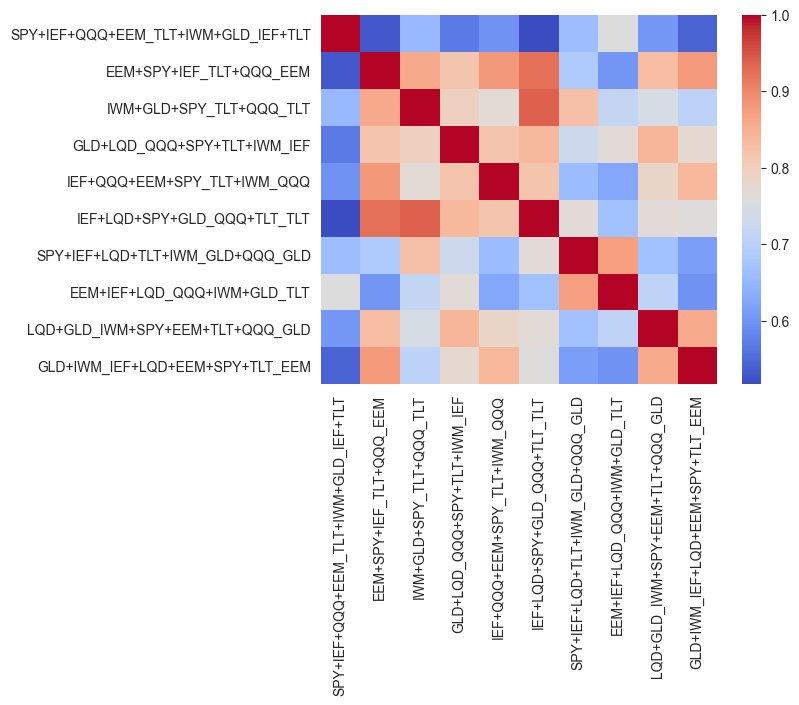

In [54]:
import seaborn as sns

# 포트폴리오 상관관계 히트맵
sns.heatmap(compare_df[top_10_cagr].pct_change().corr(), cmap="coolwarm");

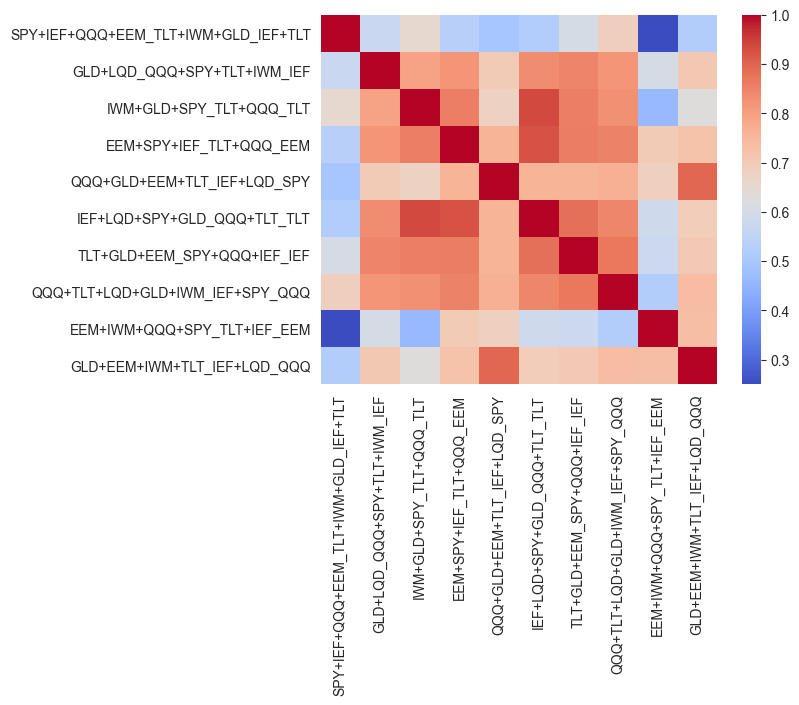

In [55]:
sns.heatmap(compare_df[top_10_sharpe_ratio].pct_change().corr(), cmap="coolwarm");